In [1]:
#Загружаем библиотеки
import seaborn as sns
import tensorflow as tf
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout,Dense, TimeDistributed, Input, RepeatVector
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import TimeDistributed


In [2]:
import pickle

In [1]:
pip install Tkinter

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement Tkinter (from versions: none)
ERROR: No matching distribution found for Tkinter

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
#функция считывает названия параметров из файла и приводит в вид для считывания
def process_excel_headers(excel_file):
  df = pd.read_csv(excel_file)
  fileheaders = list(df.columns)
  fileheaders  = [header.lower() for header in fileheaders]
  headerskey = fileheaders[1:14]
  updated_list = [ item for item in headerskey]
  jsonstring = str(updated_list)
  jsonstring = jsonstring.replace("'", '"')    
  return fileheaders, headerskey, updated_list, jsonstring

excel_file = 'data_8_without_duplicates.csv'
fileheaders, headerskey, updated_list, jsonstring = process_excel_headers(excel_file)

In [4]:
#определяем размер будущего графика и убираем сетку (если False)
mpl.rcParams['figure.figsize'] = (10, 12)
mpl.rcParams['axes.grid'] = False

C:\Users\PC\AppData\Local\Temp\ipykernel_16632\3012761482.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  date_time = pd.to_datetime(df.pop('DateTime'), infer_datetime_format=True)


Training dataset shape: (3473, 14)
Validation dataset shape: (992, 14)
Test dataset shape: (497, 14)


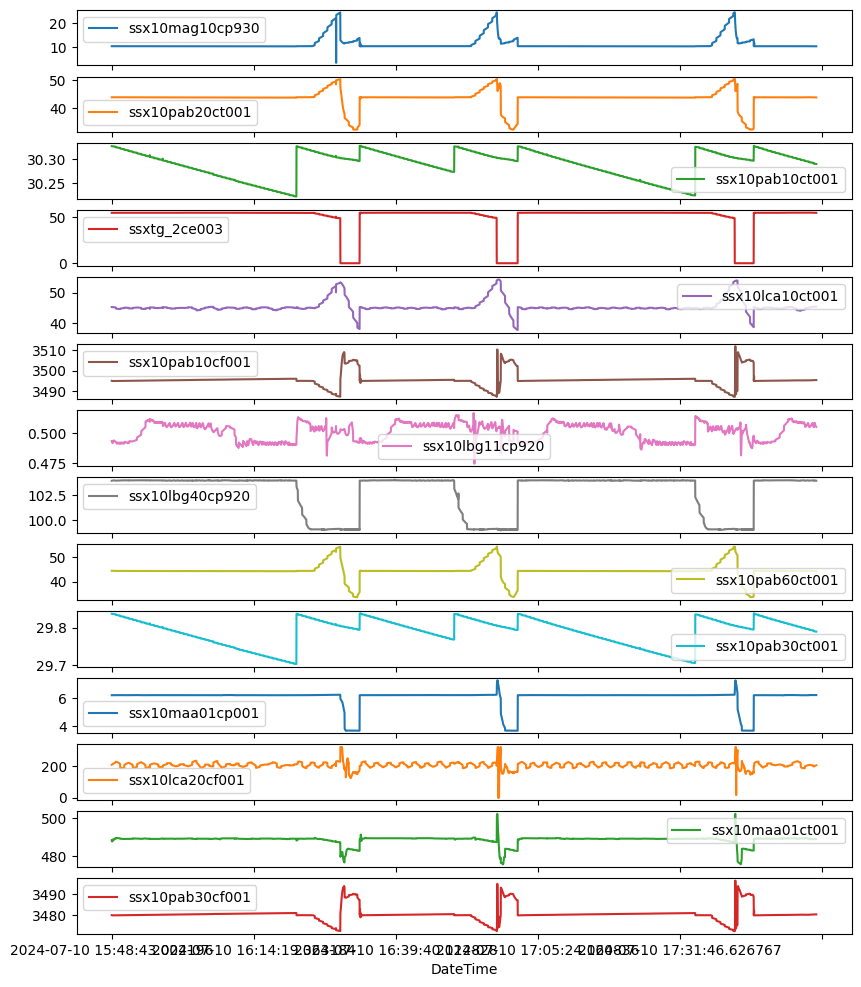

In [5]:
df = pd.read_csv('data_8_without_duplicates.csv')
df.set_index('DateTime')[['ssx10mag10cp930','ssx10pab20ct001','ssx10pab10ct001','ssxtg_2ce003','ssx10lca10ct001','ssx10pab10cf001','ssx10lbg11cp920','ssx10lbg40cp920','ssx10pab60ct001','ssx10pab30ct001','ssx10maa01cp001','ssx10lca20cf001','ssx10maa01ct001','ssx10pab30cf001']].plot(subplots=True)
df_input = df[['ssx10mag10cp930','ssx10pab20ct001','ssx10pab10ct001','ssxtg_2ce003','ssx10lca10ct001','ssx10pab10cf001','ssx10lbg11cp920','ssx10lbg40cp920','ssx10pab60ct001','ssx10pab30ct001','ssx10maa01cp001','ssx10lca20cf001','ssx10maa01ct001','ssx10pab30cf001']]
if 'DateTime' in df.columns:
    date_time = pd.to_datetime(df.pop('DateTime'), infer_datetime_format=True)
else:
    print("Столбец 'DateTime' отсутствует в датафрейме.")

TOTAL = df.shape[0]
TRAIN_VAL = int(TOTAL * 0.7)
VAL_TEST = int(TOTAL * 0.9)

my_scaler = MinMaxScaler()
df_scaled = my_scaler.fit_transform(df)
df = pd.DataFrame(df_scaled, columns=df.columns)
train_df = df[:TRAIN_VAL]
val_df = df[TRAIN_VAL:VAL_TEST]
test_df = df[VAL_TEST:]

print("Training dataset shape:", train_df.shape)
print("Validation dataset shape:", val_df.shape)
print("Test dataset shape:", test_df.shape)


In [32]:
       
INPUT_TIMES = 72
OUTPUT_TIMES = 24
# Single step dataset preparation
def multiStepSampler(df, window_input=INPUT_TIMES, window_output=OUTPUT_TIMES):
	xRes = []
	yRes = []
	for i in range(0, len(df) - window_input - window_output):
		xRes.append(df.iloc[i:i + window_input].values)
		yRes.append(df.iloc[i + window_input:i + window_input + window_output].values)
	return np.array(xRes), np.array(yRes)

C:\Users\PC\AppData\Local\Temp\ipykernel_8740\2666552140.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


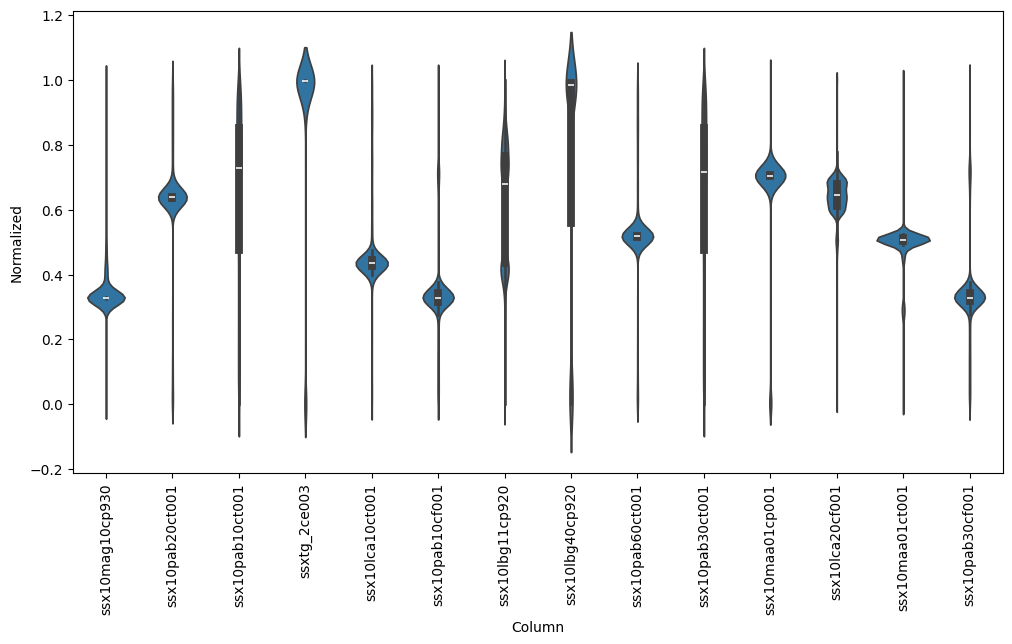

In [58]:
df_std = df.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [59]:
       
INPUT_TIMES = 72
OUTPUT_TIMES = 24
# Single step dataset preparation
def multiStepSampler(df, window_input=INPUT_TIMES, window_output=OUTPUT_TIMES):
	xRes = []
	for i in range(0, len(df) - window_input):
		xRes.append(df.iloc[i:i + window_input].values)
	return np.array(xRes)


X_test = multiStepSampler(test_df)

X_test.shape

(425, 72, 14)

In [33]:
# Dataset splitting
(X_train, y_train) = multiStepSampler(train_df)
(X_val, y_val) = multiStepSampler(val_df)
(X_test, y_test) = multiStepSampler(test_df)

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result



def plot(self, model=None, plot_col= None, max_subplots=1):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)
    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

  
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.plot = plot


multi_window = WindowGenerator(input_width=INPUT_TIMES,
                               label_width = OUTPUT_TIMES,
                               shift=OUTPUT_TIMES)

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset


def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
X_test.shape



(401, 72, 14)

In [ ]:
len(X_train)
X_train.shape[2]
X_train.shape[1]

len(X_train)


3377

In [26]:
from tensorflow.keras.layers import ConvLSTM2D


In [28]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1] * y_train.shape[2], activation='linear'),
    tf.keras.layers.Reshape([y_train.shape[1], y_train.shape[2]])
])

lstm_model.compile(loss=tf.keras.losses.Huber(),
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])

history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    shuffle=False
)
IPython.display.clear_output()

lstm_model.summary()



Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 72, 128)        │        40,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 72, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 336)            │        43,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 24, 14)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 597,362 (2.28 MB)

 Trainable params: 199,120 (777.81 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 398,242 (1.52 MB)

In [36]:
#импортирование обученной модели с весами

import pickle
lstm_model_file = "lstm_model_prediction.pkl"
with open(lstm_model_file, 'wb') as file:
    pickle.dump(lstm_model,file)

In [ ]:
X_test = df.tail(72)



C:\Users\PC\AppData\Local\Temp\ipykernel_16632\2100463713.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_timestamp = pd.to_datetime(df.iloc[-1][-1])
C:\Users\PC\AppData\Local\Temp\ipykernel_16632\2100463713.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  date_time = pd.to_datetime(df.pop('DateTime'), infer_datetime_format=True)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Shape of future_predictions: (1, 24, 14)


C:\Users\PC\AppData\Local\Temp\ipykernel_16632\2100463713.py:14: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  date_time = pd.date_range(start= last_timestamp + pd.Timedelta(seconds=1), periods=len(d_pred), freq='S')
C:\Users\PC\AppData\Local\Temp\ipykernel_16632\2100463713.py:29: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  date_time_future = pd.date_range(date_time[-1], periods=OUTPUT_TIMES, freq='S')


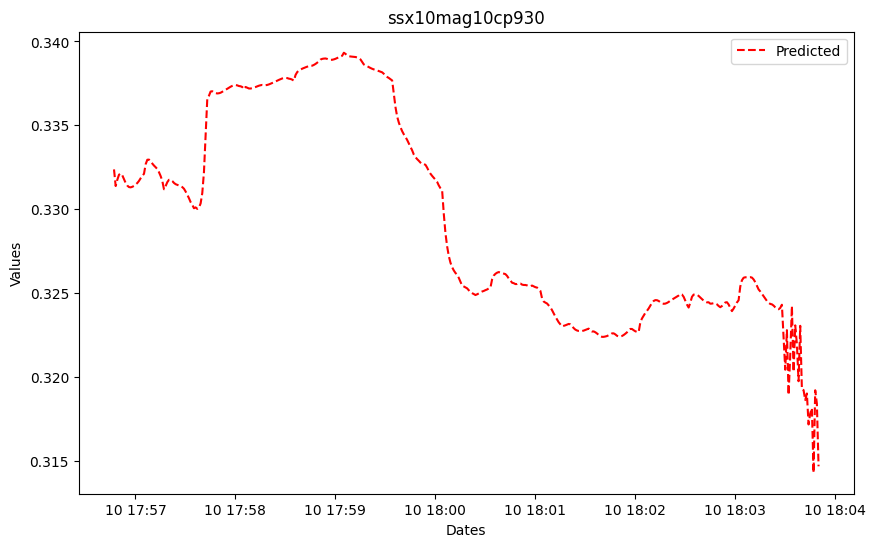

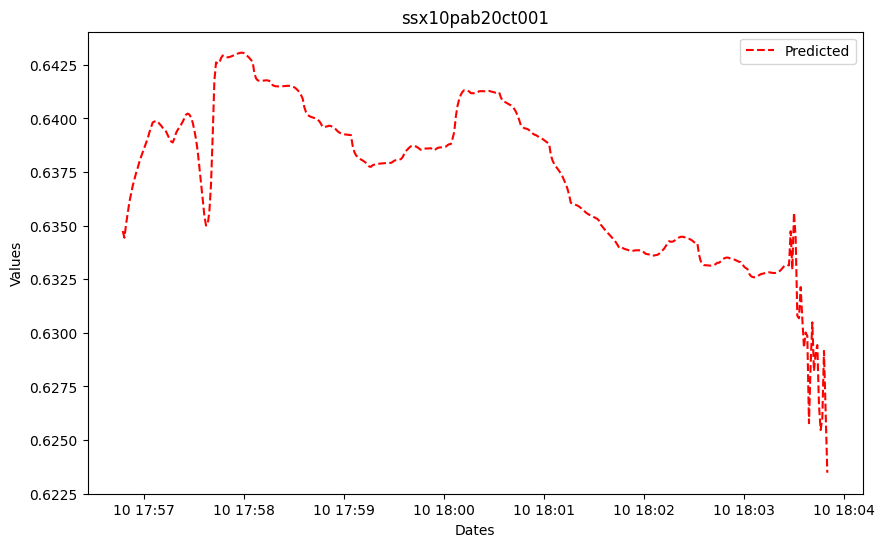

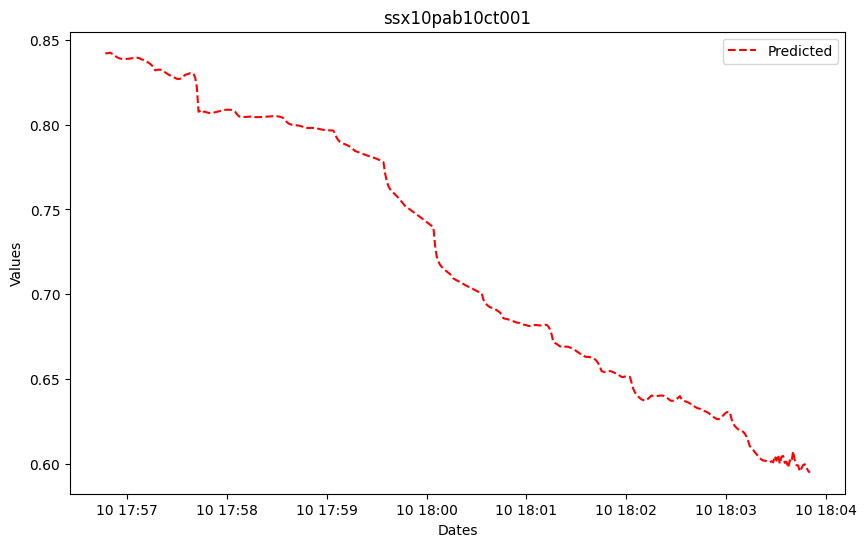

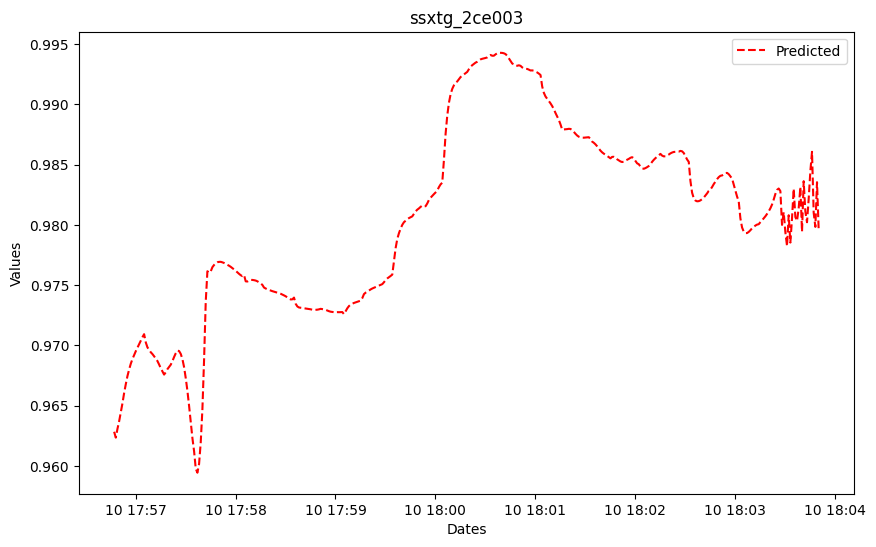

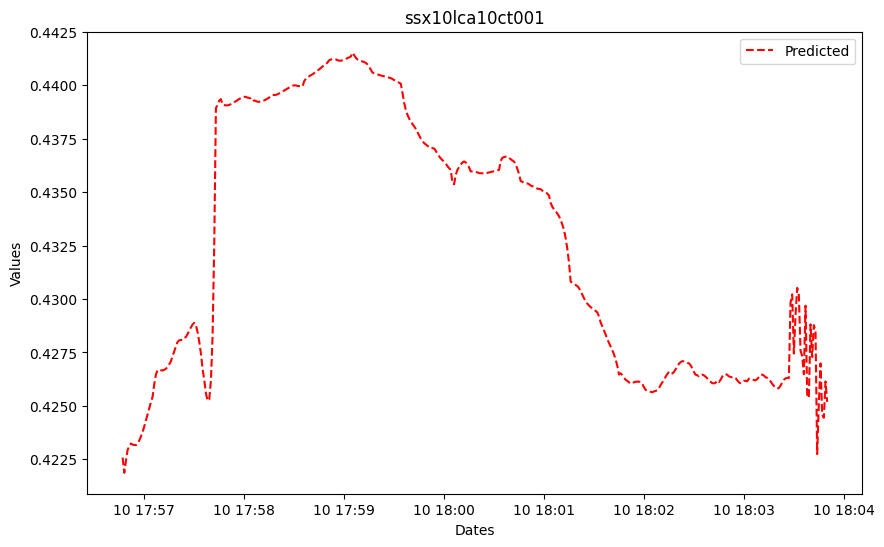

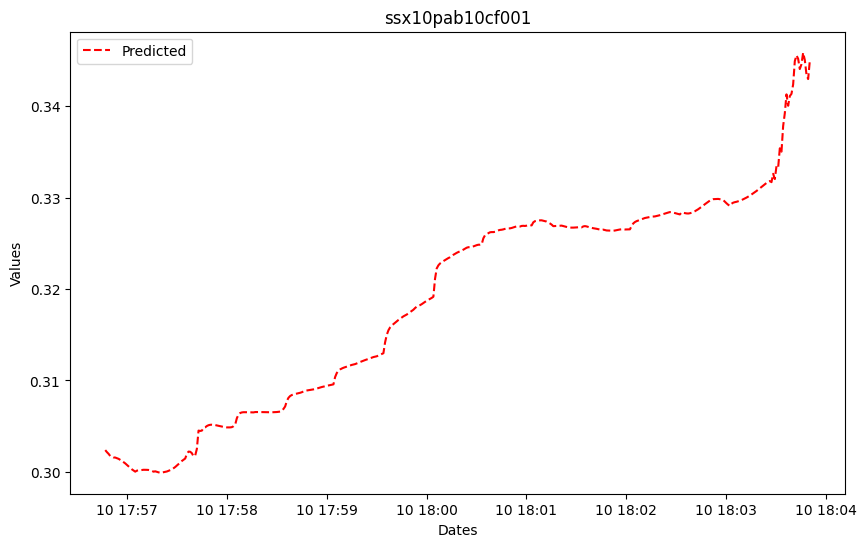

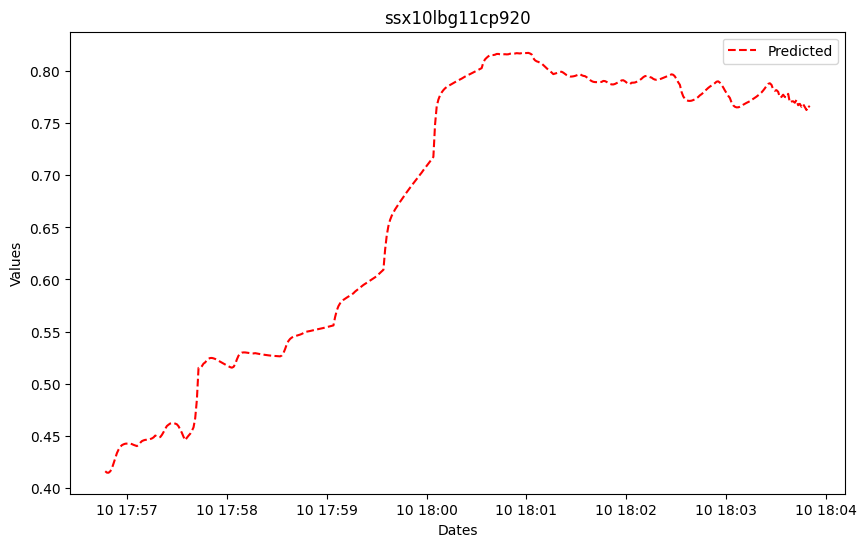

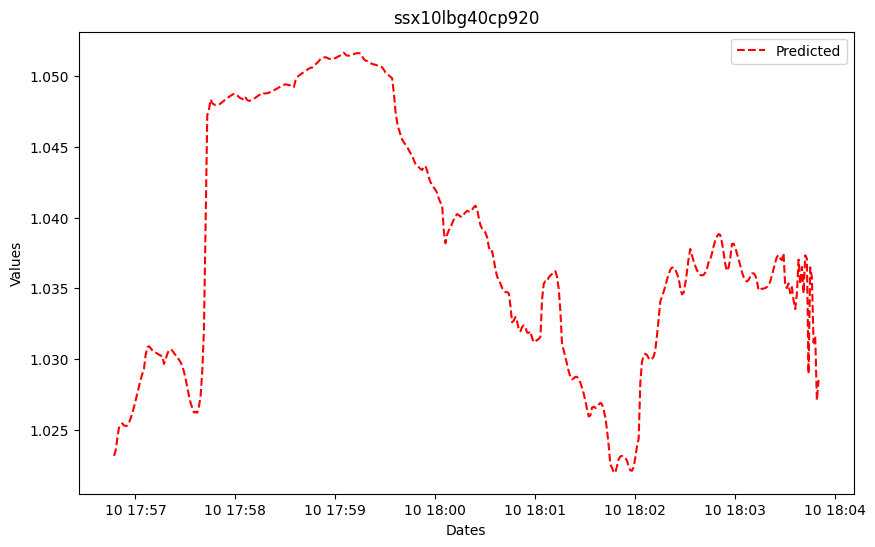

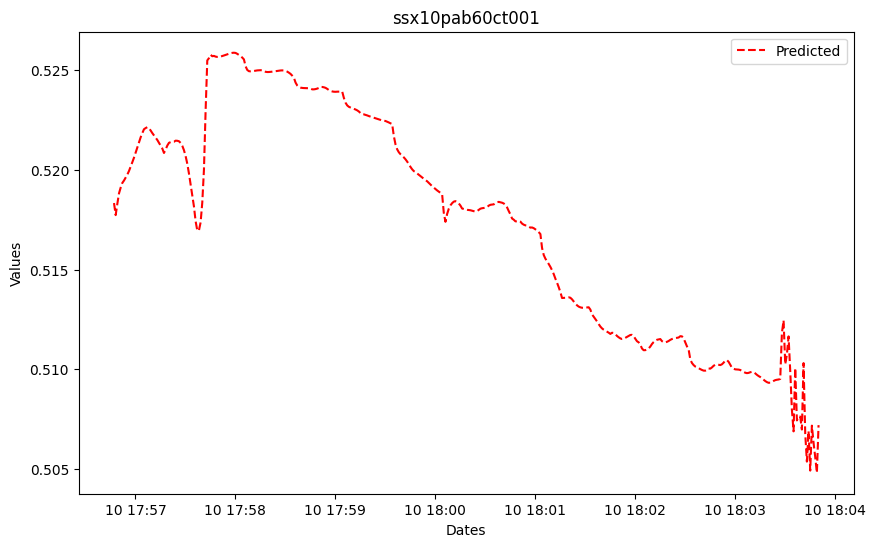

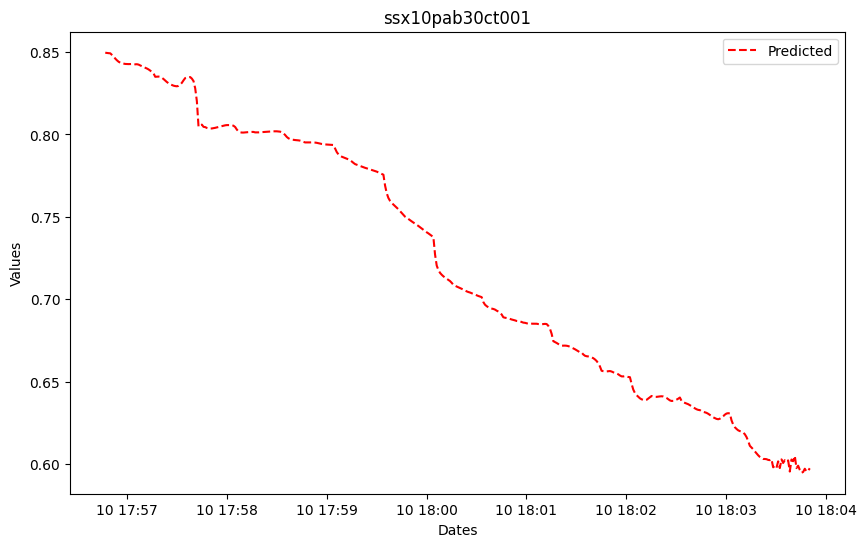

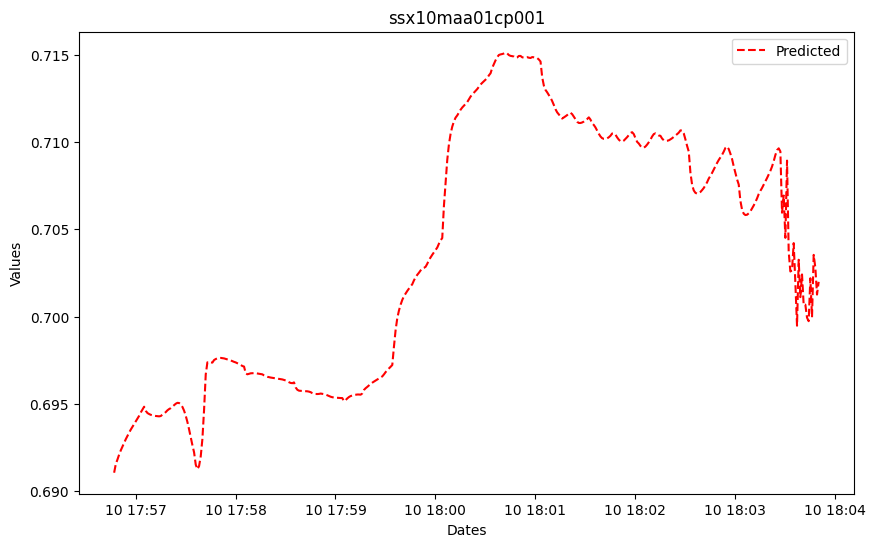

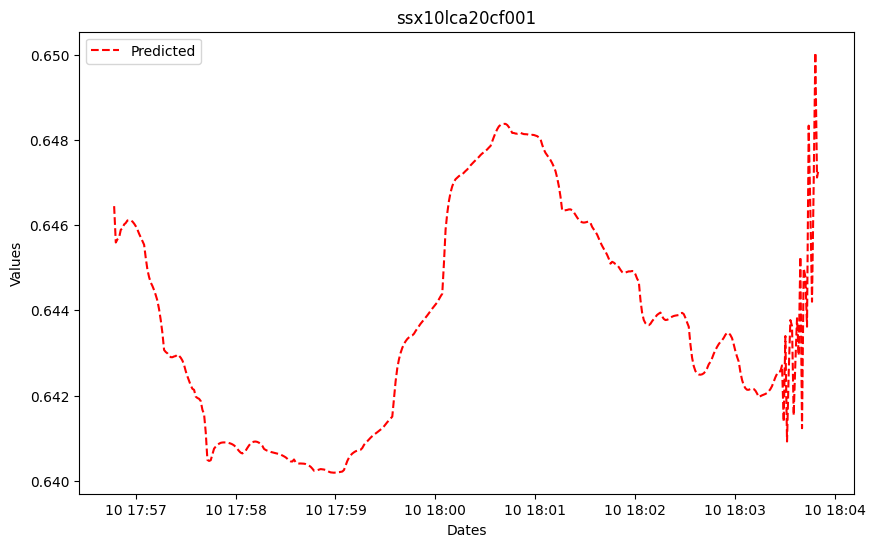

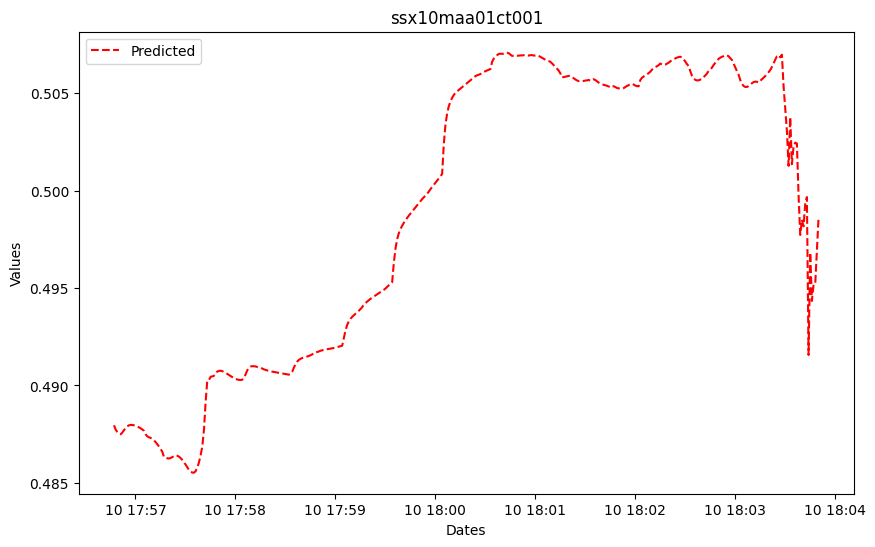

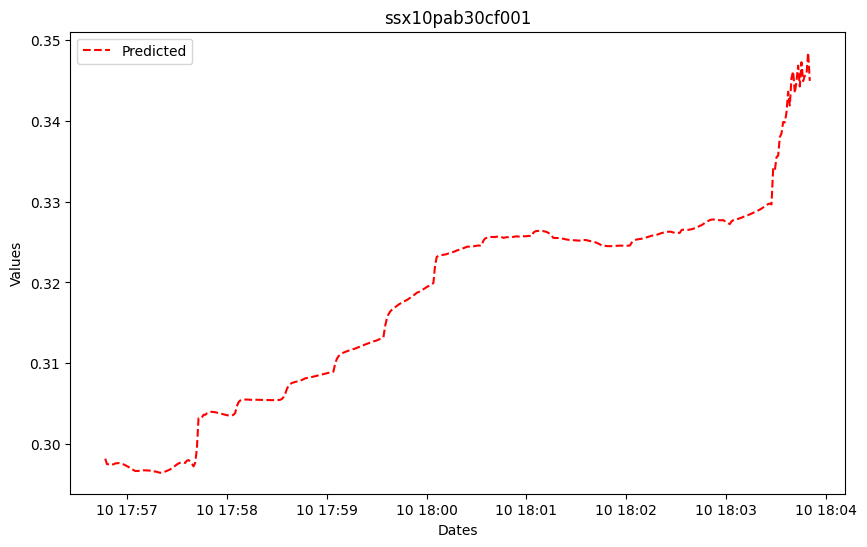

C:\Users\PC\AppData\Local\Temp\ipykernel_16632\2100463713.py:55: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  date_time = pd.date_range(start=last_timestamp + pd.Timedelta(seconds=1), periods=len(d_pred_real), freq='S')


In [34]:
df = pd.read_csv('data_8_without_duplicates.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'])
last_timestamp = pd.to_datetime(df.iloc[-1][-1])
if 'DateTime' in df.columns:
    date_time = pd.to_datetime(df.pop('DateTime'), infer_datetime_format=True)
else:
    print("Столбец 'DateTime' отсутствует в датафрейме.")


predicted_values = lstm_model.predict(X_test)
d_pred = pd.DataFrame(predicted_values[:, 0], columns=df.columns)
#last_timestamp = pd.to_datetime(df[-1][-1])
# Ensure date_time is the correct length for the predictions
date_time = pd.date_range(start= last_timestamp + pd.Timedelta(seconds=1), periods=len(d_pred), freq='S')
d_pred.index = date_time

# Future Predictions
future_input = X_test[-1].reshape(1, INPUT_TIMES, X_test.shape[2])
future_predictions = lstm_model.predict(future_input)
print("Shape of future_predictions:", future_predictions.shape)  # Check the shape

# Adjust OUTPUT_TIMES if needed
if OUTPUT_TIMES > 1:  # If you need multiple future predictions
    future_predictions = future_predictions.reshape(OUTPUT_TIMES, -1)  # Reshape if needed

future_df = pd.DataFrame(future_predictions, columns=df.columns)

# Future Date Range (adjust OUTPUT_TIMES if necessary)
date_time_future = pd.date_range(date_time[-1], periods=OUTPUT_TIMES, freq='S')
future_df.index = date_time_future

# Combine Predictions
d_pred = pd.concat([d_pred, future_df])

# Визуализация
sensors_names = list(df)[:14]

for ind, sensor in enumerate(sensors_names):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot predicted values with a dashed line
    plt.plot(d_pred[sensor], label='Predicted', color='r', linestyle='--')
    plt.title(sensor)
    plt.xlabel('Dates')
    plt.ylabel('Values')
    ax.legend()
    plt.show()

predicted_values_2d = predicted_values[:, 0]

# Обратное преобразование предсказанных значений
d_pred_real = pd.DataFrame(my_scaler.inverse_transform(predicted_values_2d), columns=df.columns)

# Создание столбца 'DateTime' с индексом времени
date_time = pd.date_range(start=last_timestamp + pd.Timedelta(seconds=1), periods=len(d_pred_real), freq='S')
d_pred_real['DateTime'] = date_time

# Сохранение DataFrame в CSV файл
d_pred_real.to_csv('predicted_values.csv', index=False)


4962
4962


C:\Users\PC\AppData\Local\Temp\ipykernel_16632\1898030130.py:21: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  date_time = pd.to_datetime(df.pop('DateTime'), infer_datetime_format=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_16632\1898030130.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_timestamp = pd.to_datetime(df.iloc[-1][-1])
C:\Users\PC\AppData\Local\Temp\ipykernel_16632\1898030130.py:40: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdep

153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
(4890, 24, 14)
    ssx10mag10cp930  ssx10pab20ct001  ssx10pab10ct001  ssxtg_2ce003  \
0         10.257135        43.755939        30.284399     54.015236   
1         10.261279        43.775383        30.284348     53.859177   
2         10.211179        43.740688        30.284681     53.943050   
3         10.182658        43.779816        30.284534     53.854027   
4         10.223156        43.759518        30.284807     53.810890   
5         10.151676        43.711002        30.284279     53.924297   
6         10.197539        43.702362        30.284643     53.821480   
7         10.264271        43.729855        30.284718     53.930714   
8         10.184294        43.704769        30.284328     54.046013   
9         10.235976        43.678062        30.284370     53.949379   
10        10.225751        43.696465        30.284082     53.955879   
11        10.166038        43.694176        30.284391     53.995628   
12        10.232807 

C:\Users\PC\AppData\Local\Temp\ipykernel_16632\1898030130.py:47: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  predicted_timestamps = pd.date_range(start=last_timestamp + pd.Timedelta(seconds=1), periods=OUTPUT_TIMES, freq='S')


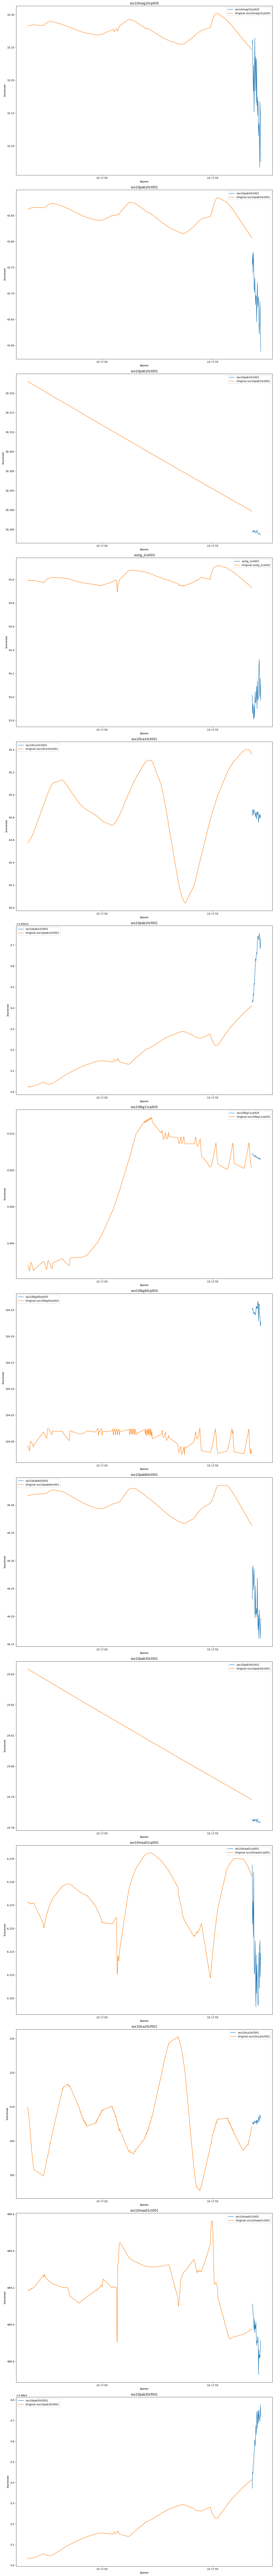

In [35]:
df = pd.read_csv('data_8_without_duplicates.csv')
import matplotlib.dates as mdates
INPUT_TIMES = 72
OUTPUT_TIMES = 24
# Single step dataset preparation


def multiStepSampler(df, window_input=INPUT_TIMES, window_output=OUTPUT_TIMES):
	xRes = []
	for i in range(0, len(df) - window_input):
		xRes.append(df.iloc[i:i + window_input].values)
	return np.array(xRes)

X_test = multiStepSampler(df)

def make_prediction(file_name = 'data_8_without_duplicates.csv'):
    df = pd.read_csv(file_name)
    print(len(df))
    df.dropna(inplace=True)
    if 'DateTime' in df.columns:
       date_time = pd.to_datetime(df.pop('DateTime'), infer_datetime_format=True)
    else:
       print("Столбец 'DateTime' отсутствует в датафрейме.")
       return
    selected_columns = df.columns[:]
    TOTAL = df.shape[0]
    LAST_VALUECES = 72
    if TOTAL >=LAST_VALUECES:
       original_df = df.copy().tail(400)
       scaler = MinMaxScaler()
       df_scaled = scaler.fit_transform(df)
       df = pd.DataFrame(df_scaled,columns=df.columns)
       test_df = df
       X_test = multiStepSampler(test_df)
       df = pd.read_csv(file_name)
       print(len(df))
       df['DateTime'] = pd.to_datetime(df['DateTime'])
       last_timestamp = pd.to_datetime(df.iloc[-1][-1])
       if 'DateTime' in df.columns:
              date_time = pd.to_datetime(df.pop('DateTime'), infer_datetime_format=True)
       else:
           print("Столбец 'DateTime' отсутствует в датафрейме.")
       predicted_values = lstm_model.predict(X_test)
       print(predicted_values.shape)
       predicted_values = predicted_values[-1]
       predicted_values = scaler.inverse_transform(predicted_values)
       predicted_timestamps = pd.date_range(start=last_timestamp + pd.Timedelta(seconds=1), periods=OUTPUT_TIMES, freq='S')
       predicted_df = pd.DataFrame(predicted_values, columns=selected_columns)
       print(predicted_df)
       predicted_df['DateTime'] = predicted_timestamps
       predicted_df = predicted_df.set_index('DateTime')
       # Переместить столбец DateTime в конец
       predicted_df.to_csv('predicted_values_updated.csv', index=False) 
       
       #predicted_df.to_csv('predicted_values.csv')
       original_df['DateTime'] = date_time
       original_df = original_df.set_index('DateTime')
       # Строим график
       fig, axes = plt.subplots(nrows=len(selected_columns), ncols=1, figsize=(15, 10 * len(selected_columns)))
       for i, column in enumerate(selected_columns):
         
           axes[i].plot(predicted_df.index, predicted_df[column], label=column)
           axes[i].plot(original_df.index, original_df[column], label='Original ' + column)
           axes[i].set_xlabel("Время")
           axes[i].set_ylabel("Значение")
           axes[i].set_title(column)
           axes[i].legend()

       # Выравниваем подграфики
       plt.tight_layout()

       plt.show()


make_prediction()

#predicted_df = pd.read_csv('predicted_values.csv')

# Переместить столбец DateTime в конец
#predicted_df = predicted_df[['ssx10mag10cp930','ssx10pab20ct001','ssx10pab10ct001','ssxtg_2ce003','ssx10lca10ct001','ssx10pab10cf001','ssx10lbg11cp920','ssx10lbg40cp920','ssx10pab60ct001','ssx10pab30ct001','ssx10maa01cp001','ssx10lca20cf001','ssx10maa01ct001','ssx10pab30cf001','DateTime']]

# Сохранить в файл
#predicted_df.to_csv('predicted_values_updated.csv', index=False) 

4962
4962


C:\Users\PC\AppData\Local\Temp\ipykernel_16632\2847054427.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  date_time = pd.to_datetime(df.pop('DateTime'), infer_datetime_format=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_16632\2847054427.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_timestamp = pd.to_datetime(df.iloc[-1][-1])
C:\Users\PC\AppData\Local\Temp\ipykernel_16632\2847054427.py:29: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps

153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
(4890, 24, 14)
    ssx10mag10cp930  ssx10pab20ct001  ssx10pab10ct001  ssxtg_2ce003  \
0         10.537144        44.177956        30.288464     55.431435   
1         10.517463        44.164349        30.288441     55.427422   
2         10.525080        44.168407        30.288366     55.338749   
3         10.499632        44.152653        30.288366     55.349266   
4         10.494401        44.154057        30.288357     55.280357   
5         10.487459        44.145233        30.288347     55.174969   
6         10.480918        44.112041        30.288340     55.271435   
7         10.467406        44.120178        30.288273     55.274563   
8         10.450949        44.096619        30.288170     55.134827   
9         10.453338        44.078358        30.288179     55.207218   
10        10.435638        44.064812        30.288134     55.249043   
11        10.421566        44.056046        30.288101     55.091324   
12        10.416881 

C:\Users\PC\AppData\Local\Temp\ipykernel_16632\2847054427.py:36: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  predicted_timestamps = pd.date_range(start=last_timestamp + pd.Timedelta(seconds=1), periods=OUTPUT_TIMES, freq='S')


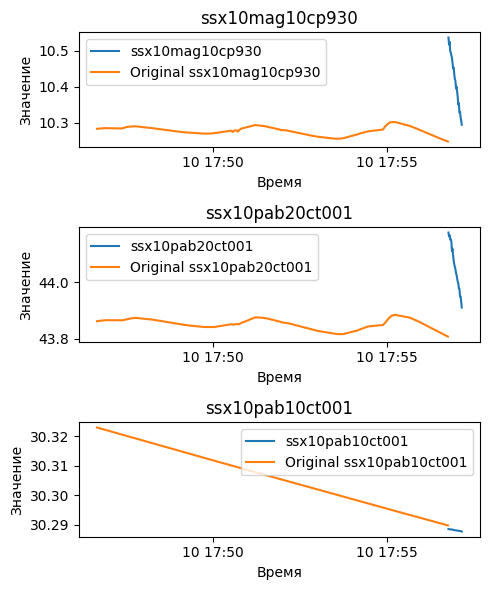

In [23]:

def make_prediction(file_name = 'data_8_without_duplicates.csv'):
    df = pd.read_csv(file_name)
    X_test = multiStepSampler(df)
    print(len(df))
    df.dropna(inplace=True)
    if 'DateTime' in df.columns:
       date_time = pd.to_datetime(df.pop('DateTime'), infer_datetime_format=True)
    else:
       print("Столбец 'DateTime' отсутствует в датафрейме.")
       return
    selected_columns = df.columns[:]
    TOTAL = df.shape[0]
    LAST_VALUECES = 72
    if TOTAL >=LAST_VALUECES:
       if len(df) >= 400:
        original_df = df.copy().tail(400)  # Take last 400
       else:
        original_df = df.copy()
       scaler = MinMaxScaler()
       df_scaled = scaler.fit_transform(df)
       df = pd.DataFrame(df_scaled,columns=df.columns)
       test_df = df
       X_test = multiStepSampler(test_df)
       df = pd.read_csv(file_name)
       print(len(df))
       df['DateTime'] = pd.to_datetime(df['DateTime'])
       last_timestamp = pd.to_datetime(df.iloc[-1][-1])
       if 'DateTime' in df.columns:
              date_time = pd.to_datetime(df.pop('DateTime'), infer_datetime_format=True)
       else:
           print("Столбец 'DateTime' отсутствует в датафрейме.")
       predicted_values = lstm_model.predict(X_test)
       print(predicted_values.shape)
       predicted_values = predicted_values[-1]
       predicted_values = scaler.inverse_transform(predicted_values)
       predicted_timestamps = pd.date_range(start=last_timestamp + pd.Timedelta(seconds=1), periods=OUTPUT_TIMES, freq='S')
       predicted_df = pd.DataFrame(predicted_values, columns=selected_columns)
       print(predicted_df)
       predicted_df['DateTime'] = predicted_timestamps
       predicted_df = predicted_df.set_index('DateTime')
       # Переместить столбец DateTime в конец
       predicted_df.to_csv('predicted_values_updated.csv', index=False) 
       
       #predicted_df.to_csv('predicted_values.csv')
       original_df['DateTime'] = date_time
       original_df = original_df.set_index('DateTime')
       # Строим график
       fig, axes = plt.subplots(nrows=len(selected_columns[:3]), ncols=1, figsize=(12, 4 * len(selected_columns[:3])), num="Предиктивная аналитика. Предсказания")
       fig.set_size_inches(10, 12)

       plt.subplots_adjust(left=0.15, bottom=0.2,hspace=0.2, right=0.75)

       for i, column in enumerate(selected_columns[:3]):
         
           axes[i].plot(predicted_df.index, predicted_df[column], label=column)
           axes[i].plot(original_df.index, original_df[column], label='Original ' + column)
           axes[i].set_xlabel("Время")
           axes[i].set_ylabel("Значение")
           axes[i].figure.set_figheight(6)  # Высота каждого подграфика
           axes[i].figure.set_figwidth(5)  # Ширина каждого подграфика
           axes[i].set_title(column)
           axes[i].legend()

       # Выравниваем подграфики
       plt.tight_layout()

       plt.show()

#make_prediction()

predicted_df = pd.read_csv('predicted_values_updated.csv')

# Переместить столбец DateTime в конец
#predicted_df = predicted_df[['ssx10mag10cp930','ssx10pab20ct001','ssx10pab10ct001','ssxtg_2ce003','ssx10lca10ct001','ssx10pab10cf001','ssx10lbg11cp920','ssx10lbg40cp920','ssx10pab60ct001','ssx10pab30ct001','ssx10maa01cp001','ssx10lca20cf001','ssx10maa01ct001','ssx10pab30cf001','DateTime']]

# Сохранить в файл
predicted_df.to_csv('predicted_values_updated.csv', index=False) 


#root.mainloop()




#def make_realprediction(file_name = 'cached_data_1.csv'):
    #df = pd.read_csv(file_name)
    #X_test = multiStepSampler(df)
    #print(len(df))
    #df.dropna(inplace=True)  
    #selected_columns = df.columns[:]
    #TOTAL = df.shape[0]
    #LAST_VALUECES = 72
    #if TOTAL >=LAST_VALUECES:
       #for i in range(LAST_VALUECES, TOTAL + 1, 1):
            # Берем последние i строк
            #current_df = df.tail(i)
            #if 'DateTime' in current_df.columns:
                 #date_time = pd.to_datetime(current_df.pop('DateTime'), infer_datetime_format=True)
            #else:
               #print("Столбец 'DateTime' отсутствует в датафрейме.")
            #print(f"Обрабатываем строки: {i}")
            #if len(df) >= 400:
               #original_df = current_df.copy().tail(400)
            #else:
                #original_df = current_df.copy()
            #scaler = MinMaxScaler()

            #df_scaled = scaler.fit_transform(current_df)
            #current_df = pd.DataFrame(df_scaled,columns=current_df.columns)
            #X_test = multiStepSampler(current_df)
            #current_df = df.tail(i)
            #current_df['DateTime'] = pd.to_datetime(current_df['DateTime'])
            #last_timestamp = pd.to_datetime(current_df.iloc[-1][-1])
            
            #if 'DateTime' in current_df.columns:
              #date_time = pd.to_datetime(current_df.pop('DateTime'), infer_datetime_format=True)
            #else:
              #print("Столбец 'DateTime' отсутствует в датафрейме.")
            #predicted_values = lstm_model.predict(X_test)
            #predicted_values = predicted_values[-1]
            #predicted_values = scaler.inverse_transform(predicted_values)
            #predicted_timestamps = pd.date_range(start=last_timestamp + pd.Timedelta(seconds=1), periods=OUTPUT_TIMES, freq='S')
            #predicted_df = pd.DataFrame(predicted_values, columns=selected_columns)
            #print(predicted_df)
            #predicted_df['DateTime'] = predicted_timestamps
            #predicted_df = predicted_df.set_index('DateTime')
           # Переместить столбец DateTime в конец
            # Сохраняем предсказанные значения
            #filename = f'predicted_values_{i}.csv'
            #predicted_df.to_csv(filename, index=False)
       
            #predicted_df.to_csv('predicted_values.csv')
            #original_df['DateTime'] = date_time
            #original_df = original_df.set_index('DateTime')
            
       # Строим график
            #fig, axes = plt.subplots(nrows=len(selected_columns[:3]), ncols=1, figsize=(12, 4 * len(selected_columns[:3])), num="Предиктивная аналитика. Предсказания")
            #fig.set_size_inches(10, 12)

            #plt.subplots_adjust(left=0.15, bottom=0.2,hspace=0.2, right=0.75)

            #for i, column in enumerate(selected_columns[:3]):
         
             #axes[i].plot(predicted_df.index, predicted_df[column], label=column)
             #axes[i].plot(original_df.index, original_df[column], label='Original ' + column)
             #axes[i].set_xlabel("Время")
             #axes[i].set_ylabel("Значение")
             #axes[i].figure.set_figheight(6)  # Высота каждого подграфика
             #axes[i].figure.set_figwidth(5)  # Ширина каждого подграфика
             #axes[i].set_title(column)
             #xes[i].legend()

       # Выравниваем подграфики
            #plt.tight_layout()

            #plt.show()
            #lt.close()

make_prediction()


In [ ]:
d_pred_real

,ssx10mag10cp930,ssx10pab20ct001,ssx10pab10ct001,ssxtg_2ce003,ssx10lca10ct001,ssx10pab10cf001,ssx10lbg11cp920,ssx10lbg40cp920,ssx10pab60ct001,ssx10pab30ct001,ssx10maa01cp001,ssx10lca20cf001,ssx10maa01ct001,ssx10pab30cf001,DateTime
0,9.469145,43.540012,30.327047,55.996704,44.253426,3494.719727,0.493250,103.980721,43.692741,29.836805,6.310026,198.946533,490.958740,3479.734131,2024-07-10 17:56:47.114577
1,9.473719,43.549187,30.327105,56.045574,44.257896,3494.720459,0.493240,103.988899,43.700584,29.836878,6.312241,199.043854,490.971893,3479.735107,2024-07-10 17:56:48.114577
2,9.467388,43.546196,30.327057,56.049519,44.251690,3494.713623,0.493188,103.994766,43.695259,29.836819,6.312194,198.939331,490.974976,3479.728027,2024-07-10 17:56:49.114577
3,9.464533,43.547466,30.327047,56.069771,44.249901,3494.711670,0.493174,104.001472,43.694622,29.836805,6.312997,198.922791,490.981140,3479.726318,2024-07-10 17:56:50.114577
4,9.451015,43.537815,30.326902,56.042854,44.240837,3494.705811,0.493175,104.006310,43.682861,29.836620,6.311733,198.741287,490.974426,3479.720459,2024-07-10 17:56:51.114577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,9.633242,43.627235,30.294975,55.882488,44.463123,3495.059082,0.509587,103.930977,43.959358,29.795841,6.252381,202.193436,489.550232,3480.068359,2024-07-10 18:03:23.114577
397,9.636290,43.627247,30.294903,55.865154,44.466553,3495.062500,0.509629,103.926392,43.961288,29.795750,6.251898,202.217026,489.544342,3480.071533,2024-07-10 18:03:24.114577
398,9.638379,43.628548,30.294849,55.863445,44.469223,3495.065918,0.509671,103.924202,43.963589,29.795679,6.251933,202.255310,489.541687,3480.074951,2024-07-10 18:03:25.114577
399,9.642323,43.630260,30.294817,55.860115,44.472164,3495.067383,0.509689,103.921165,43.966625,29.795639,6.251865,202.291245,489.539520,3480.076904,2024-07-10 18:03:26.114577


In [13]:
df = pd.read_csv('data_8_without_duplicates.csv')
#делим датасет на слайсы для построения релевантного графика
#df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%Y %H:%M')
#df = df[:2000:]
#переводит в формат дататайм
df['DateTime'] = pd.to_datetime(df['DateTime'])


#df = pd.read_csv('predicted_values_updated.csv')
#df.head(5)
#df['DateTime'] = pd.to_datetime(df['DateTime'])

In [14]:
#Разделение на время для трейна и для теста (нужно сделать как-то через пропорции или брать последние x записей)
# Assuming you have a DataFrame 'df' with a 'DateTime' column
train = df[df['DateTime'].between(pd.to_datetime('2024-07-10 17:01:51'), pd.to_datetime('2024-07-10 17:37:56'), inclusive='both')]

#val = df[df['DateTime'].between(pd.to_datetime('2024-07-10 17:01:51'), pd.to_datetime('2024-07-10 17:15:15'), inclusive='both')] 
test = df[df['DateTime'].between(pd.to_datetime('2024-07-10 16:52:00'), pd.to_datetime('2024-07-10 17:14:50'), inclusive='both')] 

checkanomaly = df[:2000]

In [15]:
# Columns to scale
variables = ['ssx10mag10cp930','ssx10pab20ct001','ssx10pab10ct001','ssxtg_2ce003','ssx10lca10ct001','ssx10pab10cf001','ssx10lbg11cp920','ssx10lbg40cp920','ssx10pab60ct001','ssx10pab30ct001','ssx10maa01cp001','ssx10lca20cf001','ssx10maa01ct001','ssx10pab30cf001']

# Extract features
train_features = train[variables]
test_features = test[variables]
#val_features = val[variables]
checkanomaly_features = checkanomaly[variables]
# Standardize the features
scaler = MinMaxScaler()
scaler.fit(train_features)
#scaler.fit(checkanomaly_features)
#scaler.fit(test_features)

train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)

checkanomaly_features = scaler.transform(checkanomaly_features)

#val_features = scaler.transform(val_features)

# Replace scaled features in DataFrames
train.loc[:, variables] = train_features  # Use .loc to assign directly to the DataFrame
test.loc[:, variables] = test_features 
checkanomaly.loc[:,variables] = checkanomaly_features
#val.loc[:, variables] = val_features


In [16]:
checkanomaly_features

array([[ 0.0377203 ,  0.11215892,  1.00233944, ...,  0.52080481,
        -0.11231756,  0.59764558],
       [ 0.04036419,  0.11369654,  1.00195908, ...,  0.53996621,
        -0.48348616,  0.58885615],
       [ 0.03933977,  0.11565577,  1.00152361, ...,  0.56976348,
        -0.64511643,  0.5812485 ],
       ...,
       [ 0.03181459,  0.10272031,  0.79713245, ...,  0.16261331,
         0.91964189,  0.66187369],
       [ 0.03166624,  0.10217744,  0.79667897, ...,  0.17740738,
         0.91849889,  0.66270032],
       [ 0.03150883,  0.10178141,  0.79633224, ...,  0.16888611,
         0.91566207,  0.66315186]])

In [17]:
# Ensure consistent seq_size
seq_size = 10

def to_sequence(x, y, seq_size):
    x_values = []
    y_values = []

    for i in range(len(x) - seq_size):
        x_values.append(x.iloc[i:(i + seq_size)].values) 
        # Extract y values for the same sequence length
        y_values.append(y.iloc[i:(i + seq_size)].values)

    return np.array(x_values), np.array(y_values)


# Corrected column selection using a list
target_columns = ['ssx10mag10cp930', 'ssx10pab20ct001', 'ssx10pab10ct001', 'ssxtg_2ce003', 
                'ssx10lca10ct001', 'ssx10pab10cf001', 'ssx10lbg11cp920', 'ssx10lbg40cp920', 
                'ssx10pab60ct001', 'ssx10pab30ct001', 'ssx10maa01cp001', 'ssx10lca20cf001', 
                'ssx10maa01ct001', 'ssx10pab30cf001']

trainX, trainY = to_sequence(train[variables], train[target_columns], seq_size)
testX, testY = to_sequence(test[variables], test[target_columns], seq_size)

#valX,valY = to_sequence(test[variables], val[target_columns], seq_size)




In [18]:
seq_size = 10

def to_sequence(x, y, seq_size):
    x_values = []
    y_values = []

    for i in range(len(x) - seq_size):
        x_values.append(x.iloc[i:(i + seq_size)].values) 
        # Extract y values for the same sequence length
        y_values.append(y.iloc[i:(i + seq_size)].values)

    return np.array(x_values), np.array(y_values)


# Corrected column selection using a list
target_columns = ['ssx10mag10cp930', 'ssx10pab20ct001', 'ssx10pab10ct001', 'ssxtg_2ce003', 
                'ssx10lca10ct001', 'ssx10pab10cf001', 'ssx10lbg11cp920', 'ssx10lbg40cp920', 
                'ssx10pab60ct001', 'ssx10pab30ct001', 'ssx10maa01cp001', 'ssx10lca20cf001', 
                'ssx10maa01ct001', 'ssx10pab30cf001']

predX, predY = to_sequence(checkanomaly[variables], checkanomaly[target_columns], seq_size)

In [19]:
seq_size = trainX.shape[1]

model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

# Компиляция модели с указанием оптимизатора
#model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │        73,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 14)         │         1,806 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,606 (807.05 KB)

 Trainable params: 206,606 (807.05 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
seq_size = predX.shape[1]

model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

# Компиляция модели с указанием оптимизатора
#model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 128)            │        73,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 14)         │         1,806 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,606 (807.05 KB)

 Trainable params: 206,606 (807.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.2876 - val_loss: 0.1531
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1152 - val_loss: 0.1249
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0820 - val_loss: 0.1177
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0680 - val_loss: 0.1144
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0614 - val_loss: 0.1168
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0570 - val_loss: 0.1186
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0539 - val_loss: 0.1147
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0507 - val_loss: 0.1191
Epoch 9/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0486 - val_loss: 0.1177
Epoch 10/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0465 - val_loss: 0.1165
Epoch 11/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0450 - val_loss: 0.1185
Epoch 12/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

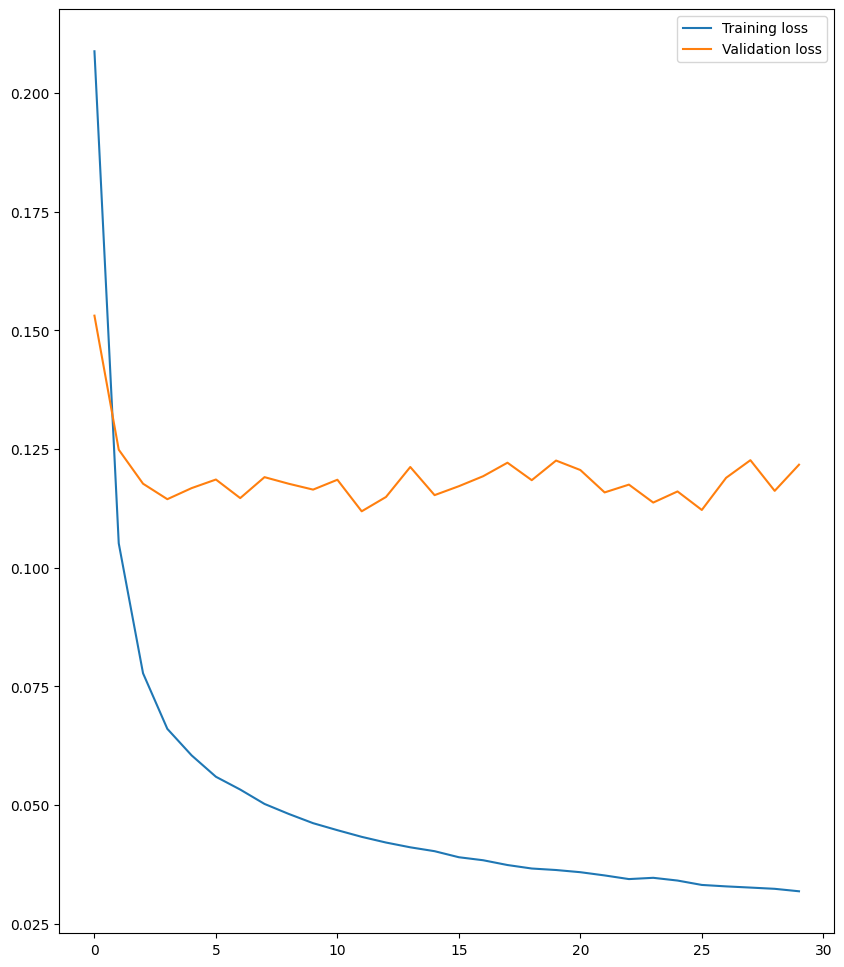

In [21]:
# fit model
history = model.fit(trainX, trainY, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [80]:

import pickle
model_check_values_file = "model_check_values.pkl"
with open(model_check_values_file, 'wb') as file:
    pickle.dump(model,file)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Length of testMAE: 851


(851, 14)

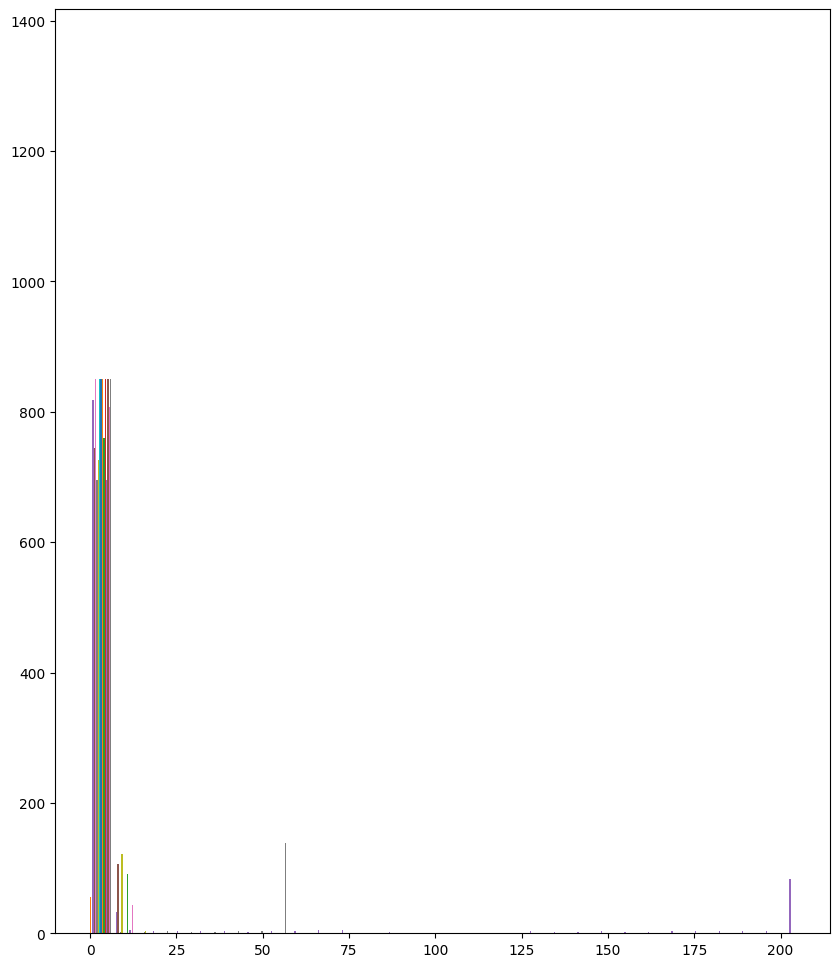

In [22]:
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30)
max_trainMAE = 0.3  #or Define 90% value of max as threshold.

testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)
print(f"Length of testMAE: {len(testMAE)}")
testMAE.shape


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Length of testMAE: 1990


(1990, 14)

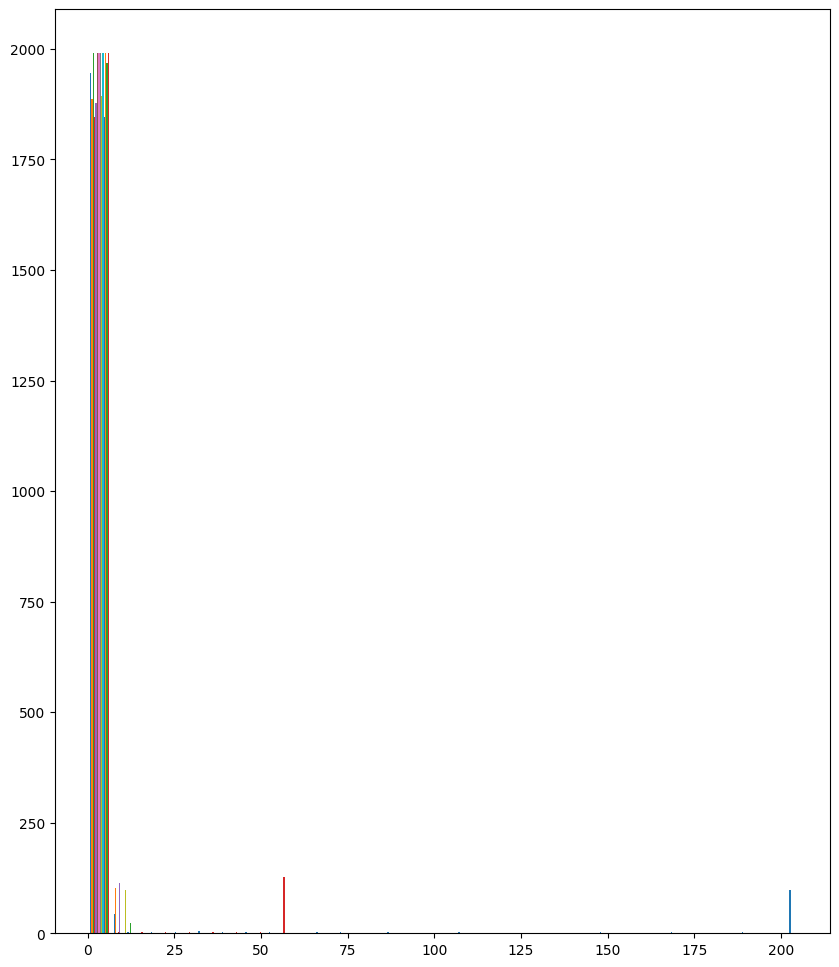

In [23]:
max_trainMAE = 0.3
predPredict = model.predict(predX)
testMAE = np.mean(np.abs(predPredict - predX), axis=1)
plt.hist(testMAE, bins=30)
print(f"Length of testMAE: {len(testMAE)}")
testMAE.shape

In [ ]:
len(d_pred)

415

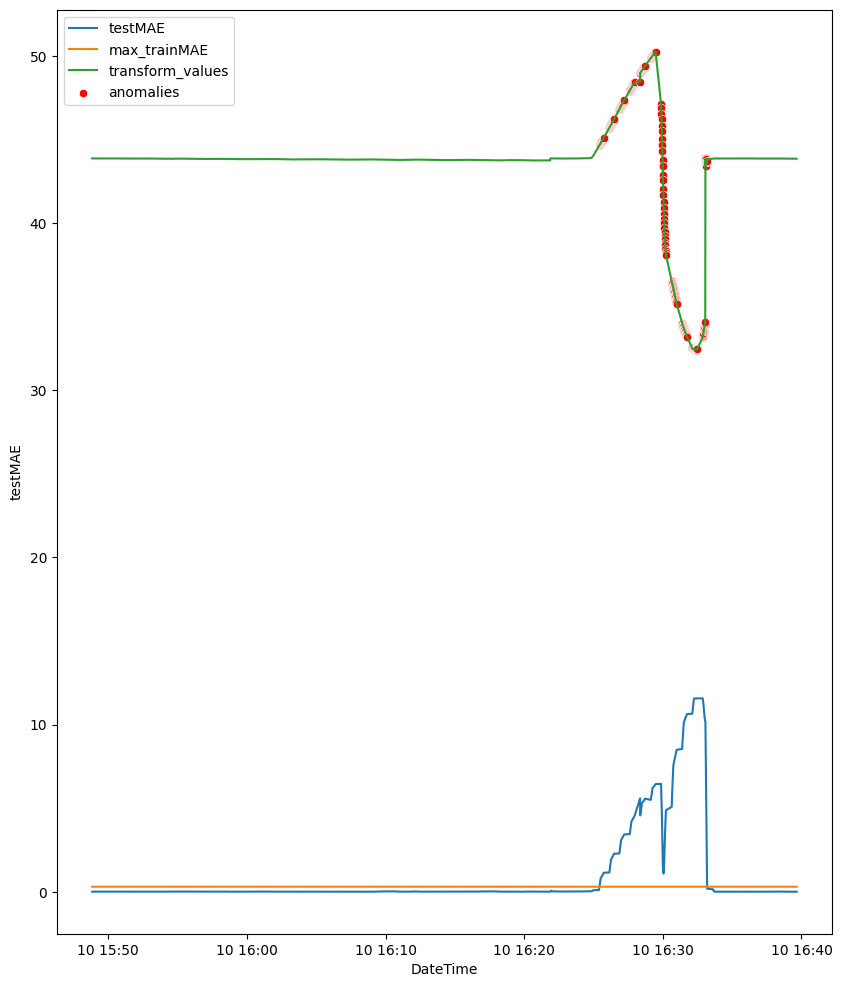

In [24]:
variables = ['ssx10mag10cp930','ssx10pab20ct001','ssx10pab10ct001','ssxtg_2ce003','ssx10lca10ct001','ssx10pab10cf001','ssx10lbg11cp920','ssx10lbg40cp920','ssx10pab60ct001','ssx10pab30ct001','ssx10maa01cp001','ssx10lca20cf001','ssx10maa01ct001','ssx10pab30cf001']


anomaly_df = pd.DataFrame(checkanomaly['ssx10pab20ct001'].iloc[seq_size:], columns=['ssx10pab20ct001'])
ssx10mag10cp930_df = pd.DataFrame(checkanomaly['ssx10pab20ct001'].iloc[seq_size:])
ssx10mag10cp930_df.columns = ['ssx10pab20ct001']

test_numeric = checkanomaly.drop(columns=['DateTime'])
test_inverse = scaler.inverse_transform(test_numeric)

#test_for_anomaly = scaler.inverse_transform(test)

# Преобразование столбца testMAE из testMAE в список
testMAE_values = testMAE[:, 1].tolist()
# Добавление столбца testMAE в anomaly_df
anomaly_df['testMAE'] = testMAE_values
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['ssx10pab20ct001'] = checkanomaly[seq_size:]['ssx10pab20ct001']
anomaly_df['DateTime'] = checkanomaly[seq_size:]['DateTime']
test_inverse = test_inverse[seq_size:, 1].tolist()
anomaly_df['transform_values'] = test_inverse
#Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df['DateTime'], y=anomaly_df['testMAE'], label='testMAE')
sns.lineplot(x=anomaly_df['DateTime'], y=anomaly_df['max_trainMAE'], label='max_trainMAE')

anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

#Plot anomalies
sns.lineplot(x=anomaly_df['DateTime'], y=anomaly_df['transform_values'], label='transform_values')

#Plot anomalies as scatter plot
sns.scatterplot(x=anomalies['DateTime'], y=anomalies['transform_values'], color='r', label='anomalies')

# Добавление легенды
plt.legend()

plt.show()

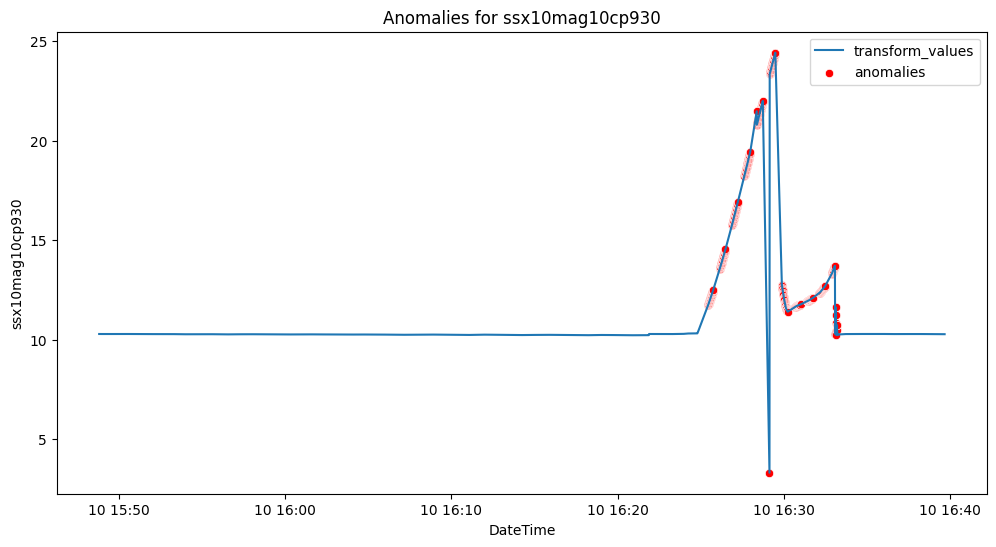

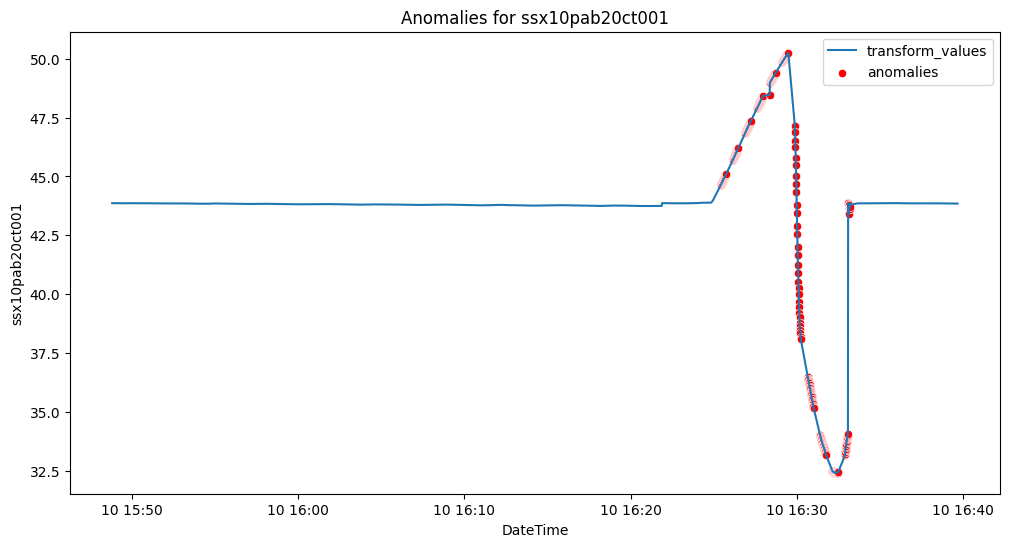

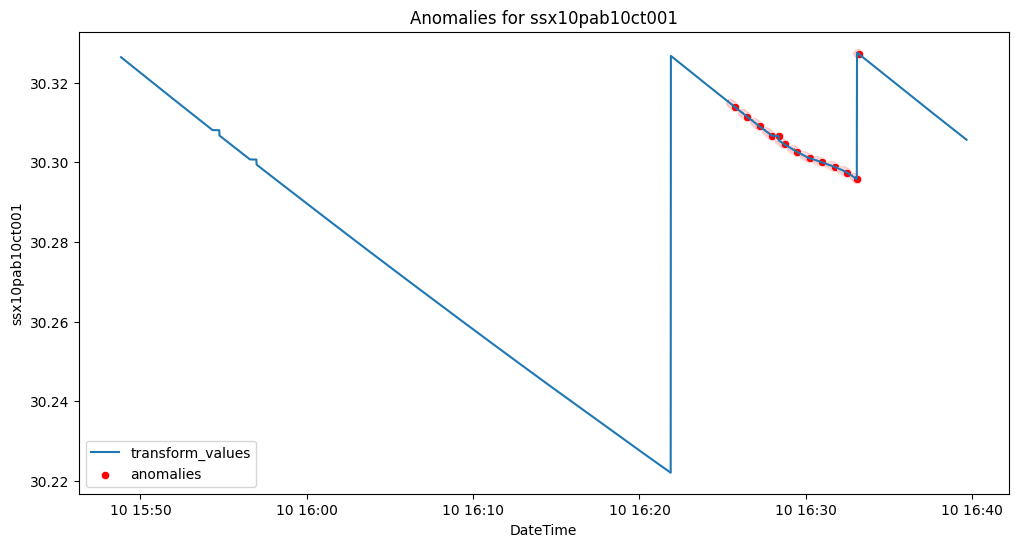

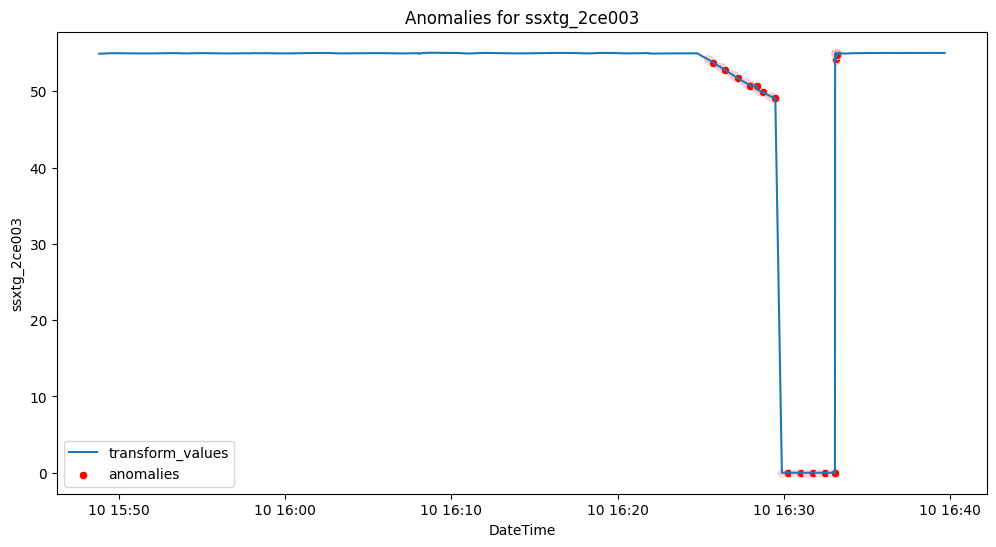

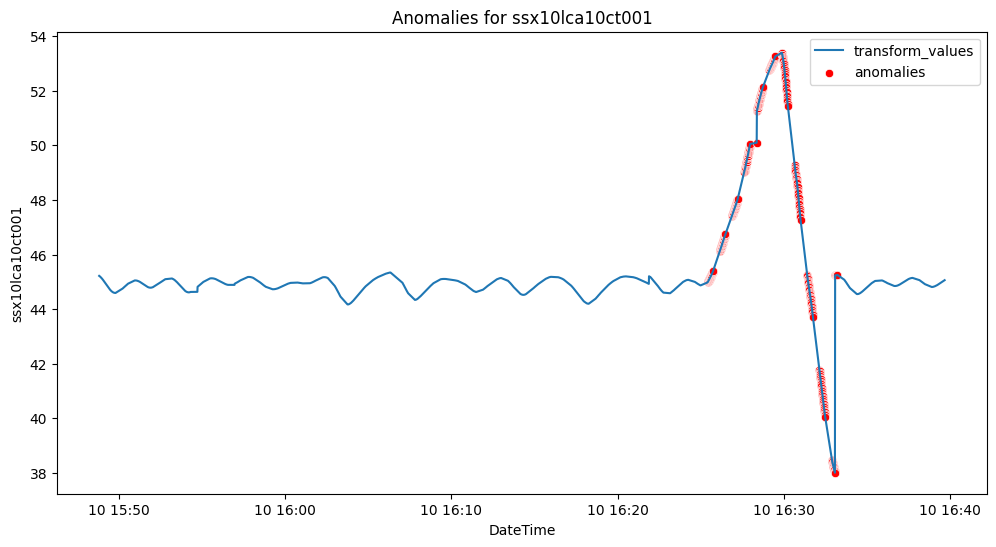

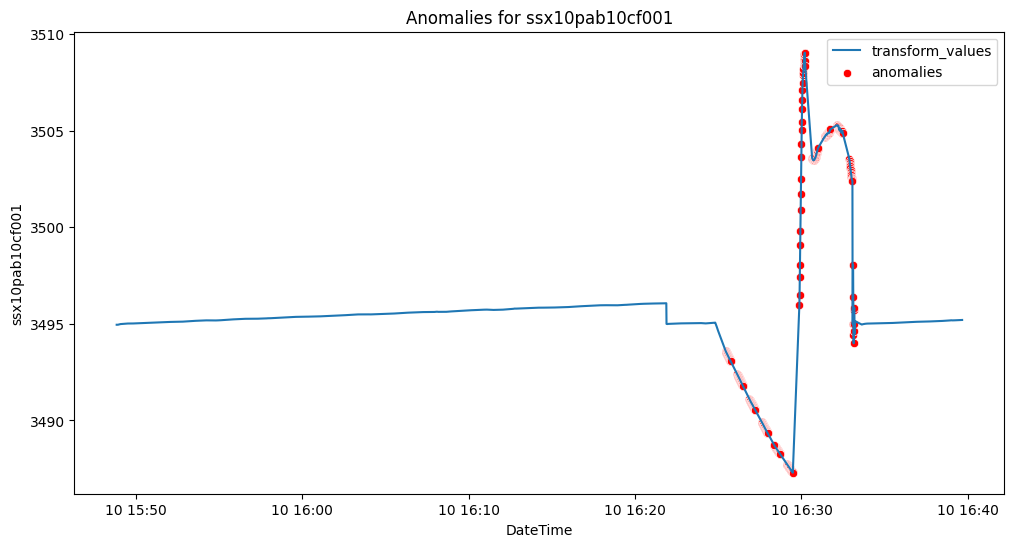

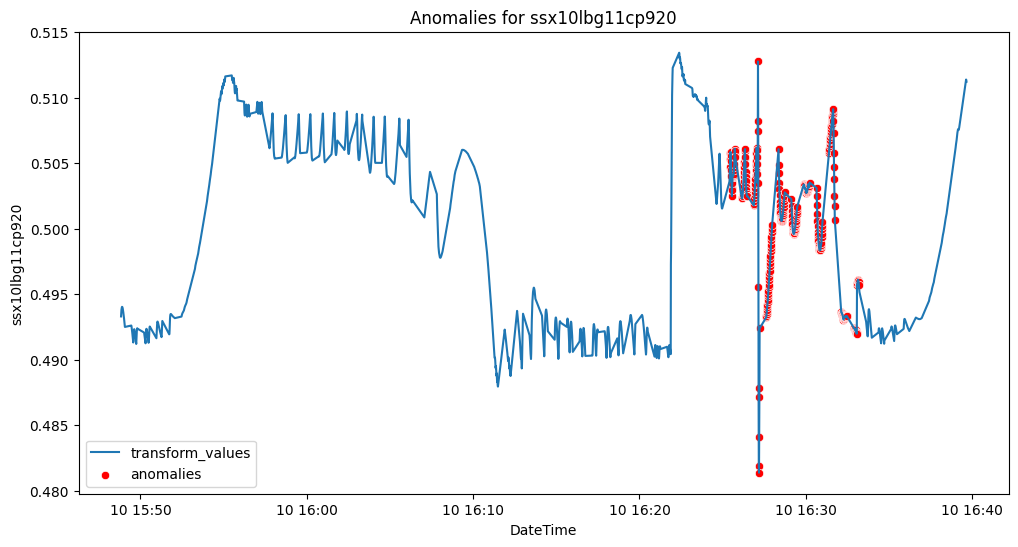

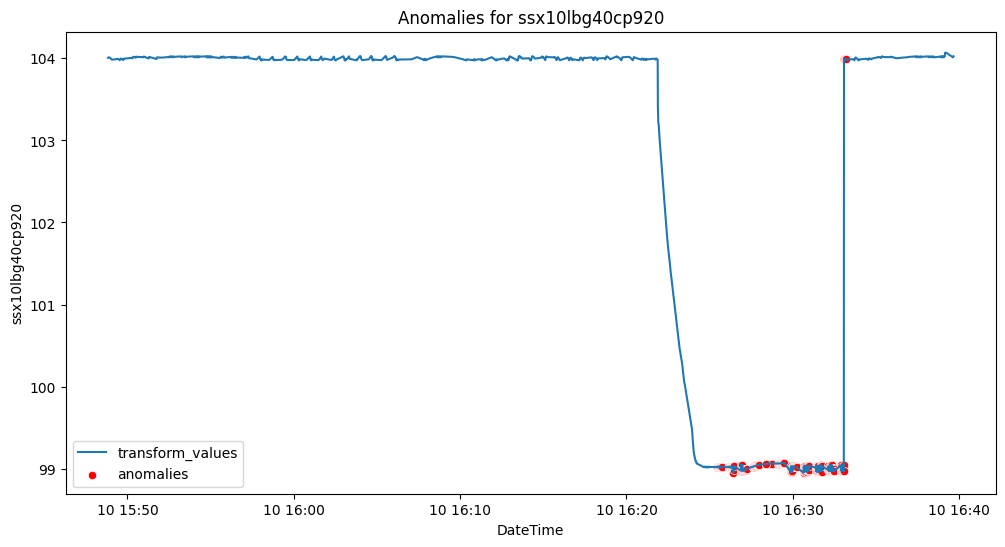

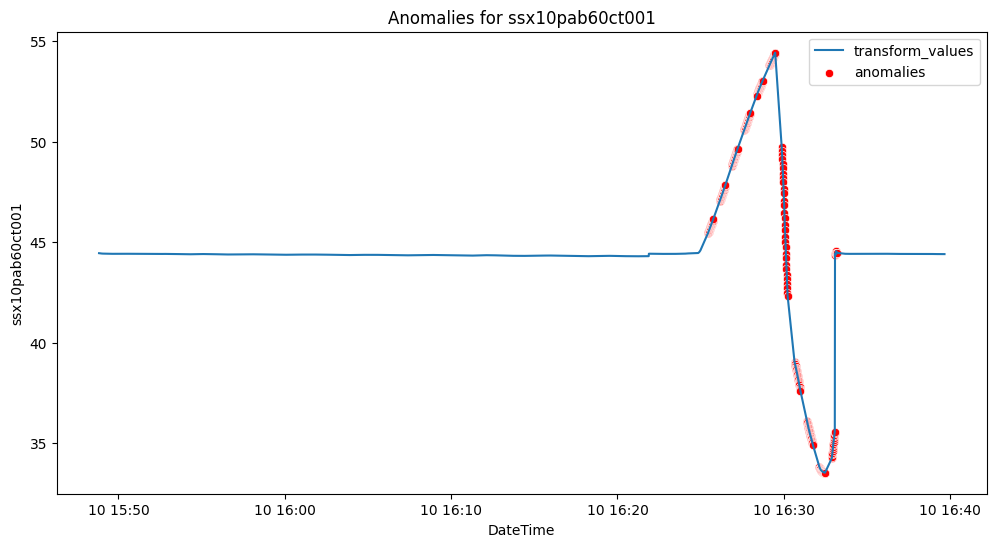

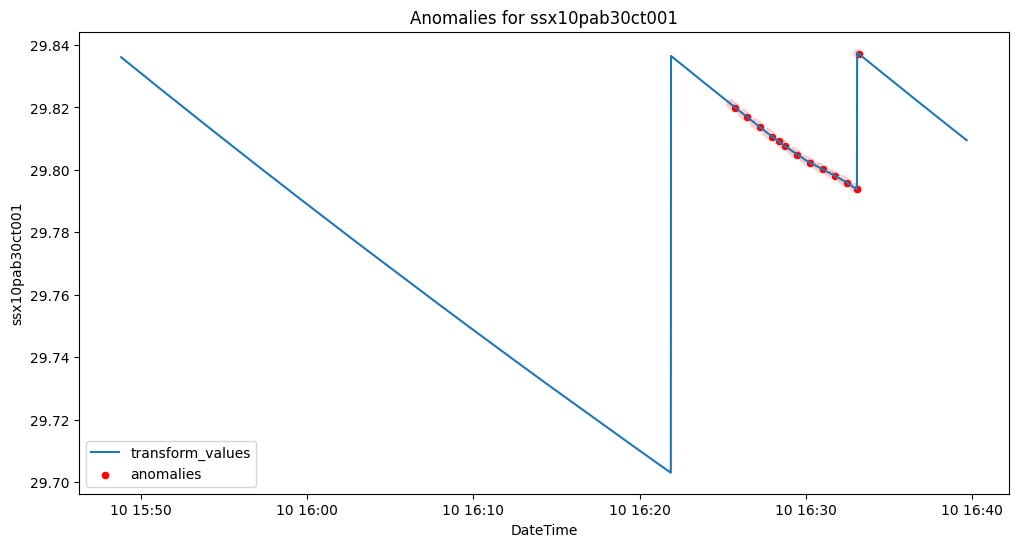

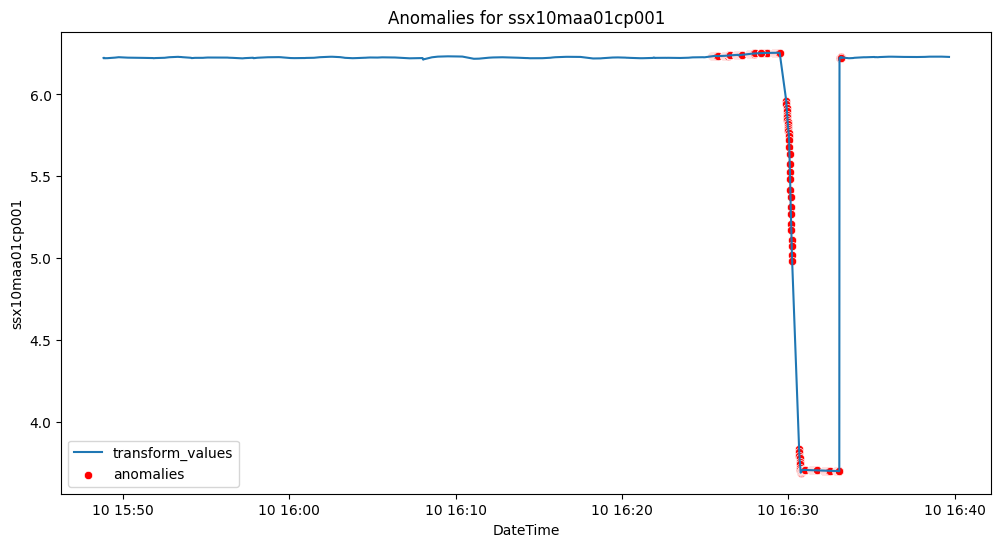

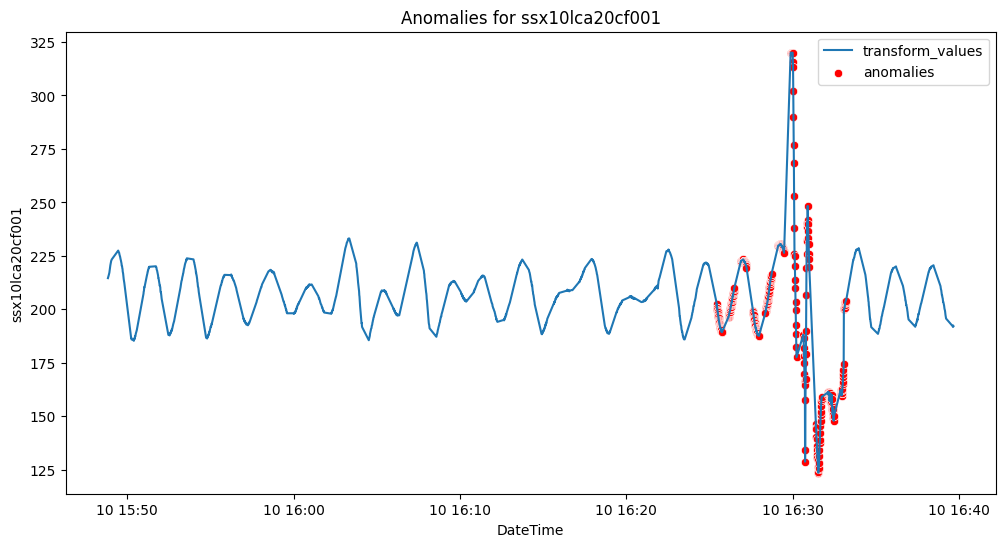

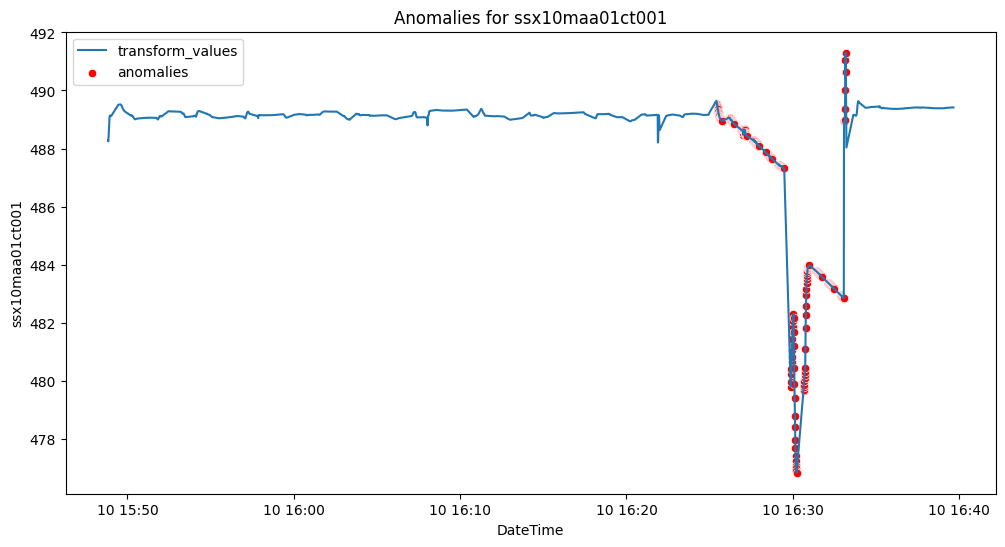

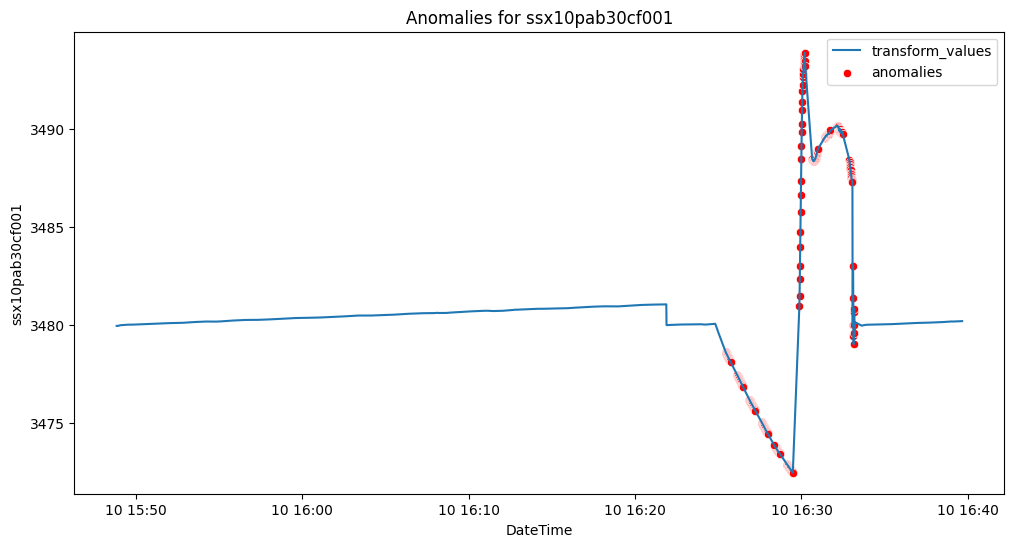

In [25]:
variables = ['ssx10mag10cp930','ssx10pab20ct001','ssx10pab10ct001','ssxtg_2ce003','ssx10lca10ct001','ssx10pab10cf001','ssx10lbg11cp920','ssx10lbg40cp920','ssx10pab60ct001','ssx10pab30ct001','ssx10maa01cp001','ssx10lca20cf001','ssx10maa01ct001','ssx10pab30cf001']

for variable in variables:
    # Create DataFrame for the current variable
    anomaly_df = pd.DataFrame(checkanomaly[variable].iloc[seq_size:], columns=[variable])
    
    # Get the testMAE values for the current variable
    testMAE_values = testMAE[:, 1].tolist()
    
    # Add columns to the DataFrame
    anomaly_df['testMAE'] = testMAE_values
    anomaly_df['max_trainMAE'] = max_trainMAE
    anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
    anomaly_df['DateTime'] = checkanomaly[seq_size:]['DateTime']
    
    # Inverse transform the values for the current variable
    test_numeric = checkanomaly.drop(columns=['DateTime'])
    test_inverse = scaler.inverse_transform(test_numeric)
    test_inverse = test_inverse[seq_size:, variables.index(variable)].tolist()
    anomaly_df['transform_values'] = test_inverse
    
    # Plot the actual values and anomalies
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=anomaly_df['DateTime'], y=anomaly_df['transform_values'], label='transform_values')
    sns.scatterplot(x=anomaly_df.loc[anomaly_df['anomaly'] == True, 'DateTime'], 
                     y=anomaly_df.loc[anomaly_df['anomaly'] == True, 'transform_values'], 
                     color='r', label='anomalies')
    plt.title(f'Anomalies for {variable}')
    plt.xlabel('DateTime')
    plt.ylabel(variable)
    plt.legend()
    plt.show()


    # Plot testMAE and max_trainMAE
    #plt.figure(figsize=(12, 6))
    #sns.lineplot(x=anomaly_df['DateTime'], y=anomaly_df['testMAE'], label='testMAE')
    #sns.lineplot(x=anomaly_df['DateTime'], y=anomaly_df['max_trainMAE'], label='max_trainMAE')
    #plt.title(f'TestMAE vs MaxTrainMAE for {variable}')
    #plt.xlabel('DateTime')
    #plt.ylabel('MAE')
    #plt.legend()
    #plt.show()

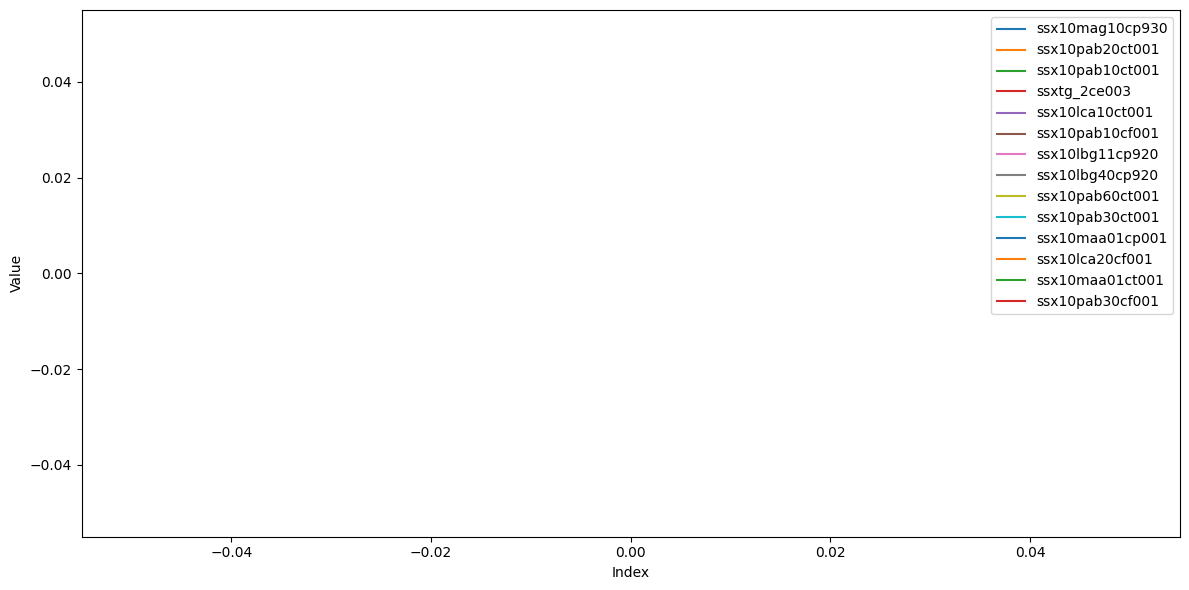

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def plot_dynamic_graph(file_name):
    ds = pd.read_csv(file_name)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    lines = [ax.plot([], [], label=param_names[i])[0] for i in range(14)]
    
    def init():
        for line in lines:
            line.set_data([], [])
        ax.set_xlabel('Index')
        ax.set_ylabel('Value')
        ax.legend()
        return lines
    
    def update(frame):
        for i in range(14):
            x = ds.index[:frame]
            y = ds[param_names[i]][:frame]
            lines[i].set_data(x, y)
        return lines
    
    ani = FuncAnimation(fig, update, frames=len(ds), init_func=init, blit=True)
    plt.tight_layout()
    plt.show()

param_names = ['ssx10mag10cp930', 'ssx10pab20ct001', 'ssx10pab10ct001', 'ssxtg_2ce003', 'ssx10lca10ct001',
               'ssx10pab10cf001', 'ssx10lbg11cp920', 'ssx10lbg40cp920', 'ssx10pab60ct001', 'ssx10pab30ct001',
               'ssx10maa01cp001', 'ssx10lca20cf001', 'ssx10maa01ct001', 'ssx10pab30cf001']

plot_dynamic_graph('data_8_without_duplicates.csv')

C:\Users\PC\AppData\Local\Temp\ipykernel_14592\4230261086.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  date_time = pd.to_datetime(df.pop('DateTime'), infer_datetime_format=True)


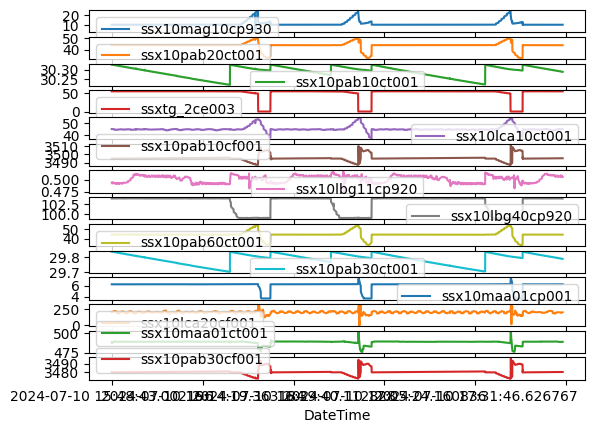

In [ ]:
import pandas as pd
def draw_graphs():
 df = pd.read_csv('data_8_without_duplicates.csv')
 df.set_index('DateTime')[['ssx10mag10cp930','ssx10pab20ct001','ssx10pab10ct001','ssxtg_2ce003','ssx10lca10ct001','ssx10pab10cf001','ssx10lbg11cp920','ssx10lbg40cp920','ssx10pab60ct001','ssx10pab30ct001','ssx10maa01cp001','ssx10lca20cf001','ssx10maa01ct001','ssx10pab30cf001']].plot(subplots=True)
 df_input = df[['ssx10mag10cp930','ssx10pab20ct001','ssx10pab10ct001','ssxtg_2ce003','ssx10lca10ct001','ssx10pab10cf001','ssx10lbg11cp920','ssx10lbg40cp920','ssx10pab60ct001','ssx10pab30ct001','ssx10maa01cp001','ssx10lca20cf001','ssx10maa01ct001','ssx10pab30cf001']]
 if 'DateTime' in df.columns:
    date_time = pd.to_datetime(df.pop('DateTime'), infer_datetime_format=True)
 else:
    print("Столбец 'DateTime' отсутствует в датафрейме.")

draw_graphs()


In [ ]:
df = pd.read_csv('readdata10.csv')
df.to_csv('readdata10copy.csv', index=False)